##### Copyright 2023 Melchor Lafuente Duque

# IMAGE STYLE TRANSFER

# SETUP

## Import and configure modules

In [2]:
import os
from os.path import join
import tensorflow as tf
import time
import pickle
import IPython.display as display

import matplotlib.pyplot as plt
import matplotlib as mpl

import numpy as np
import PIL.Image
from PIL import Image
import functools
import math

mpl.rcParams['figure.figsize'] = (12, 12)
mpl.rcParams['axes.grid'] = False

# Load compressed models from tensorflow_hub
os.environ['TFHUB_MODEL_LOAD_FORMAT'] = 'COMPRESSED'

2023-06-29 15:46:57.520405: I tensorflow/core/platform/cpu_feature_guard.cc:193] This TensorFlow binary is optimized with oneAPI Deep Neural Network Library (oneDNN) to use the following CPU instructions in performance-critical operations:  AVX2 AVX512F FMA
To enable them in other operations, rebuild TensorFlow with the appropriate compiler flags.
2023-06-29 15:46:59.071674: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer.so.7'; dlerror: libnvinfer.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:
2023-06-29 15:46:59.071801: W tensorflow/compiler/xla/stream_executor/platform/default/dso_loader.cc:64] Could not load dynamic library 'libnvinfer_plugin.so.7'; dlerror: libnvinfer_plugin.so.7: cannot open shared object file: No such file or directory; LD_LIBRARY_PATH: /usr/local/cuda-11.2/lib64:/usr/local/cuda/lib64:
2023-06-29 15:46:59.07

In [3]:
def tensor_to_image(tensor):
    
    # Scale the tensor values to the range [0, 255]
    tensor = tensor*255
    
    # Convert the tensor to a NumPy array with unsigned 8-bit integers
    tensor = np.array(tensor, dtype=np.uint8)
    
    # If the tensor has more than three dimensions, assume it has a batch dimension and extract the first element
    if np.ndim(tensor)>3:
        assert tensor.shape[0] == 1
        tensor = tensor[0]
        
    # Create a PIL Image object from the tensor array and return it
    return PIL.Image.fromarray(tensor)

In [4]:
dir_name_input_1 = "OUTPUT_2/ORIGIN"
dir_name_input_2 = "OUTPUT_2/STYLE"
content_path = join(dir_name_input_1, "ORIGINAL_image.png")
style_path = join(dir_name_input_2, "STYLE_image.png")

## Preprocess the images by slicing them:

We define a function to load an image and limit its maximum dimension to 512 pixels if wanted:

In [6]:
def load_img(path_to_img, scale_it = False):
    
    # Set the maximum dimension for resizing the image to 512
    max_dim = 512
    
    # Read the image file from the specified path
    img = tf.io.read_file(path_to_img)
    
    # Decode the image into a tensor with 3 channels
    img = tf.image.decode_image(img, channels=3)
    
    # Convert the image tensor to float32 data type
    img = tf.image.convert_image_dtype(img, tf.float32)

    # Get the shape of the image tensor and cast it to float32
    shape = tf.cast(tf.shape(img)[:-1], tf.float32)
    
    # Find the longest dimension of the image
    long_dim = max(shape)

    # Set the scale factor to 1 by default
    scale = 1 

    # If scale_it flag is True, calculate the scale factor based on the maximum dimension
    if scale_it:
        scale = max_dim / long_dim

    # Calculate the new shape for resizing the image (if scale_it flag was True it might have changed)
    new_shape = tf.cast(shape * scale, tf.int32)

    # Resize the image tensor using the new shape (if scale_it flag was True it might have changed)
    img = tf.image.resize(img, new_shape)
    
    # Add a batch dimension to the image tensor
    img = img[tf.newaxis, :]
    
    # Return the preprocessed image tensor
    return img

In [7]:
full_content_image = load_img(content_path)
full_style_image = load_img(style_path)
print(full_content_image.shape, full_style_image.shape)

(1, 662, 21341, 3) (1, 662, 21341, 3)


<br> 
Since the content image is much larger than the style image, we need to increase the size of the style image so that it has at least the same dimensions as the content image. To do this, what we will do is calculate how many times the content image is wider and longer than the style image in order to paste as many style images together as necessary until both images have at least the same dimensions. 
<br>
<br>
First we need a function to find out how many times the content image is wider and longer than the style image:

In [8]:
def obtain_repetitions(full_content_image, full_style_image):
    # Calculate the number of horizontal repetitions needed to cover the full width of the content image with the style image
    horizontal_repetitions = math.ceil(full_content_image.shape[2] / full_style_image.shape[2])
    
    # Calculate the number of vertical repetitions needed to cover the full height of the content image with the style image
    vertical_repetitions = math.ceil(full_content_image.shape[1] / full_style_image.shape[1])
    
    # Return the number of horizontal and vertical repetitions
    return horizontal_repetitions, vertical_repetitions

We create a simple function to display an image:

In [10]:
def imshow(image, title=None):
    if len(image.shape) > 3:
        image = tf.squeeze(image, axis=0)

    plt.imshow(image)
    if title:
        plt.title(title)

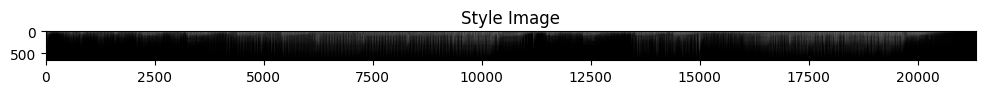

In [11]:
imshow(full_style_image, 'Style Image')

Now we have two large images that are impossible to manage by the neural network we'll create... Unless we slice them. By this way, we'll have as many slices in the first image as in the second and we'll take peer of slices: One from the content image and other from the style image and we'll make the first one to be similar to the second one.
<br>
<br>
For doing this, first we have to calculate how many slices will we need:

In [12]:
def num_slices(tf_im_1, tf_im_2, max_dim = 512):
    
    # Find the maximum number of rows between the two images
    max_rows = max(tf_im_1.shape[1], tf_im_2.shape[1]) 
    
    # Find the maximum number of columns between the two images
    max_cols = max(tf_im_1.shape[2], tf_im_2.shape[2])
    
    # Return as a tuple:
    # - The number of row slices needed to cover the maximum dimension
    # - The number of column slices needed to cover the maximum dimension
    return math.ceil(max_rows / max_dim), math.ceil(max_cols / max_dim) 

Then we calculate the dimensions of each slice:

In [13]:
def slice_length(tf_im, row_slices, col_slices):
    
    # Calculate the length of each row slice by dividing the number of rows by the row_slices
    row_length = int(tf_im.shape[1] / row_slices)
    
    # Calculate the length of each column slice by dividing the number of columns by the col_slices
    col_length = int(tf_im.shape[2] / col_slices)
    
    # Return the row length and column length as a tuple
    return row_length, col_length

After that, we define a function to subtract pieces that go from a given position to another:

In [14]:
def slice_img(tf_im, read_from_row = 0, read_to_row=512, read_from_col = 0, read_to_col=512):
    # Slice the image tensor by specifying the row and column ranges
    return tf_im[:, read_from_row:read_to_row, read_from_col:read_to_col, :]

Finally, we define a function that slices a image by knowing the number of slices that we'll need as well as the dimensions of each:

In [15]:
def matrix_of_images(tf_im, row_slices, col_slices, row_length, col_length):
    
    # Create an array of dimensions 2x20 filled with None values
    array_rowsxcols = np.empty((row_slices, col_slices), dtype=object)

    # Iterate over the rows and columns to slice the image tensor
    for i in range(row_slices):
        for j in range(col_slices):
            # Calculate the row and column ranges for slicing
            rf = i * row_length
            if(i != row_slices - 1):
                rt = (i * row_length) + row_length
            else:
                rt = None

            cf = j * col_length
            if(j != col_slices - 1):
                ct = (j * col_length) + col_length
            else:
                ct = None

            # Slice the image tensor using the specified ranges and store it in the array
            array_rowsxcols[i,j] = slice_img(tf_im, read_from_row = rf, read_to_row = rt, read_from_col = cf, read_to_col= ct)
    
    # Return the matrix of image slices
    return array_rowsxcols

Here's the whole process for slicing the content and the style image:

In [16]:
# Calculate the number of row and column slices required to merge the full content and style images
row_slices, col_slices = num_slices(full_content_image, full_style_image)

# Create an empty numpy array to store the final image matrix
final_image = np.empty((row_slices, col_slices), dtype=object)

# Calculate the length of each row and column slice for the content image
rows_length_c, cols_length_c = slice_length(full_content_image, row_slices, col_slices)

# Calculate the length of each row and column slice for the style image
rows_length_s, cols_length_s = slice_length(full_style_image, row_slices, col_slices)

# Create a matrix of image slices for the content images
content_images = matrix_of_images(full_content_image, row_slices, col_slices, rows_length_c, cols_length_c)

# Create a matrix of image slices for the style images
style_images = matrix_of_images(full_style_image, row_slices, col_slices, rows_length_s, cols_length_s)

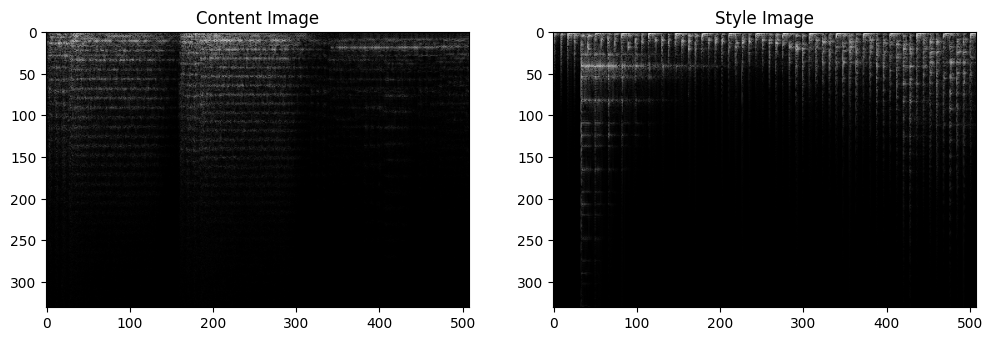

In [23]:
plt.subplot(1, 2, 1)
imshow(content_images[0,0], 'Content Image')

plt.subplot(1, 2, 2)
imshow(style_images[0,0], 'Style Image')

## Functions to read and write matrices of slices:

**Note:** We will need the following functions right at the end of the code. Anyway, now that we have defined the process for slicing the images, it makes sense for them to appear here so that we don't lose the common thread of the features created.

In [15]:
def write_matrix_of_arrays(file, output_dir_name = "OUTPUT_3", filename = "final_image_sliced"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    full_path_to_file = os.path.join(output_path, filename + ".pickle")

    with open(full_path_to_file, 'wb') as f:
        pickle.dump(file, f)

In [16]:
def read_matrix_of_arrays(input_dir_name = "OUTPUT_3", filename = "final_image_sliced"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, input_dir_name)
    full_path_to_file = os.path.join(output_path, filename + ".pickle")
    
    with open(full_path_to_file, 'rb') as f:
        file = pickle.load(f)
    return file

## Function to combine the slices generating a unique image:

**Note:** As with the preavious functions, we will need the next function right in the end of the code.

In [14]:
def combine_images(images_matrix):
    rows, cols = images_matrix.shape
    combined_cols = []

    for i in range(rows):
        for j in range(cols):
            if (j == 0):
                img = np.array(tensor_to_image(images_matrix[i,j]))
            else:
                img = np.hstack((img, np.array(tensor_to_image(images_matrix[i,j]))))

        combined_cols.append(img)

    img = combined_cols[0]
    for i in range(1, rows):
        img = np.vstack((img, combined_cols[i]))

    return img

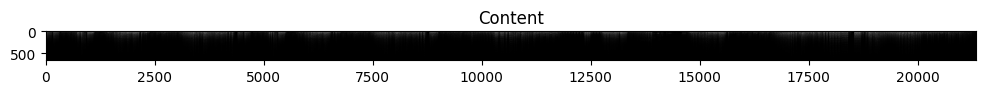

In [21]:
imshow(combine_images(content_images), 'Content')

## Define content and style representations

We will utilize the intermediate layers of the model to extract the representations of content and style from the image. Commencing from the input layer of the network, the initial layers capture lower-level features such as edges and textures. As we progress deeper into the network, the subsequent layers depict higher-level features, including object components like wheels or eyes. In this particular scenario, we are employing the VGG19 network architecture, which is a pretrained model primarily designed for image classification. These intermediate layers play a crucial role in defining the representations of content and style derived from the images. By selecting appropriate intermediate layers, we can strive to match the corresponding target representations of style and content for a given input image.


So, we choose intermediate layers from the network to represent the style and content of the image:

In [27]:
content_layers = ['block5_conv2'] 

style_layers = ['block1_conv1',
                'block2_conv1',
                'block3_conv1', 
                'block4_conv1', 
                'block5_conv1']

num_content_layers = len(content_layers)
num_style_layers = len(style_layers)

#### Intermediate layers for style and content

Why do these intermediate outputs within our pretrained image classification network allow us to define representations of style and content?

At a fundamental level, for a network to perform image classification, it needs to comprehend the image. This involves taking the raw image as input pixels and constructing an internal representation that transforms the raw pixels into a sophisticated understanding of the image's characteristics.

This ability is also why convolutional neural networks exhibit strong generalization capabilities: they can capture the inherent properties and distinguishing features of classes (e.g., cats vs. dogs) that remain unaffected by background noise and other irrelevant factors. Hence, between the input image and the final classification label, the model functions as a sophisticated feature extractor. By accessing the intermediate layers of the model, we gain the ability to describe the content and style of input images.

# BUILD THE MODEL

The `tf.keras.applications` package provides networks that are specifically designed to facilitate the extraction of intermediate layer values using the Keras functional API.

To create a model using the functional API, you need to define the inputs and outputs as follows:

`model = Model(inputs, outputs)`

The subsequent function constructs a VGG19 model that generates a list containing the intermediate layer outputs:

In [ ]:
def vgg_layers(layer_names):
    # Load our model. Load pretrained VGG, trained on ImageNet data
    vgg = tf.keras.applications.VGG19(include_top=False, weights='imagenet')
    
    # Set the VGG19 model to be non-trainable
    vgg.trainable = False

    # Get the intermediate outputs corresponding to the specified layer names
    outputs = [vgg.get_layer(name).output for name in layer_names]

    # Create a new model that takes the VGG19 input and outputs the specified intermediate outputs
    model = tf.keras.Model([vgg.input], outputs)
    
    # Return the VGG model with the specified intermediate outputs
    return model

## Calculate the style

The intermediate feature maps contain the information that represents the content of an image.

Interestingly, the style of an image can be characterized by the statistical means and correlations across various feature maps. To capture this information, we can compute a Gram matrix by performing the outer product of the feature vector with itself at each location and then averaging the outer product over all locations. Specifically, the Gram matrix for a specific layer can be calculated as follows:

$$G^l_{cd} = \frac{\sum_{ij} F^l_{ijc}(x)F^l_{ijd}(x)}{IJ}$$

We can achieve a concise implementation of this by utilizing the `tf.linalg.einsum` function:

In [ ]:
def gram_matrix(input_tensor):
    
    # Use the einsum function to perform the matrix multiplication and reduction
    result = tf.linalg.einsum('bijc,bijd->bcd', input_tensor, input_tensor)
    
    # Get the shape of the input tensor
    input_shape = tf.shape(input_tensor)
    
    # Compute the number of locations in the feature map
    num_locations = tf.cast(input_shape[1]*input_shape[2], tf.float32)
    
    # Normalize the result by dividing it by the number of locations
    return result/(num_locations)

## Extract style and content


Let's build a model that returns the style and content tensors:

In [ ]:
class StyleContentModel(tf.keras.models.Model):
    def __init__(self, style_layers, content_layers):
        super(StyleContentModel, self).__init__()
        
        # Create a VGG model with the specified style and content layers
        self.vgg = vgg_layers(style_layers + content_layers)
        
        # Store the style and content layers for later reference
        self.style_layers = style_layers
        self.content_layers = content_layers
        
        # Store the number of style layers
        self.num_style_layers = len(style_layers)
        
        # Set the VGG model to be non-trainable
        self.vgg.trainable = False

    def call(self, inputs):
        "Expects float input in [0,1]"
        
        # Scale the input values from [0, 1] to [0, 255]
        inputs = inputs*255.0
        
        # Preprocess the input using the VGG19 preprocess_input function
        preprocessed_input = tf.keras.applications.vgg19.preprocess_input(inputs)
        
        # Pass the preprocessed input through the VGG model to get the outputs
        outputs = self.vgg(preprocessed_input)
        
        # Split the outputs into style and content outputs
        style_outputs, content_outputs = (outputs[:self.num_style_layers],
                                          outputs[self.num_style_layers:])

        # Compute the Gram matrix for each style output
        style_outputs = [gram_matrix(style_output)
                         for style_output in style_outputs]

        # Create a dictionary with content layer names as keys and content outputs as values
        content_dict = {content_name: value
                        for content_name, value
                        in zip(self.content_layers, content_outputs)}

        # Create a dictionary with style layer names as keys and style outputs as values
        style_dict = {style_name: value
                      for style_name, value
                      in zip(self.style_layers, style_outputs)}

        # Return a dictionary containing the content and style information
        return {'content': content_dict, 'style': style_dict}

## Gradient descent

Using this style and content extractor, we can proceed to implement the style transfer algorithm. We can accomplish this by calculating the mean square error between the output of our image and each target, and then obtaining the weighted sum of these losses.

Since this is a float image, we define a function to keep the pixel values between 0 and 1:

In [ ]:
def clip_0_1(image):
    return tf.clip_by_value(image, clip_value_min=0.0, clip_value_max=1.0)

To optimize this, we use a weighted combination of the two losses to get the total loss:

In [ ]:
style_weight=1e-2
content_weight=1e4

In [ ]:
def style_content_loss(outputs):
    
    # Extract the style and content outputs from the dictionary
    style_outputs = outputs['style']
    content_outputs = outputs['content']
    
    # Compute the style loss by comparing the style outputs to the style targets
    style_loss = tf.add_n([tf.reduce_mean((style_outputs[name]-style_targets[name])**2) 
                           for name in style_outputs.keys()])
    style_loss *= style_weight / num_style_layers

    content_loss = tf.add_n([tf.reduce_mean((content_outputs[name]-content_targets[name])**2) 
                             for name in content_outputs.keys()])
    content_loss *= content_weight / num_content_layers
    
    # Combine the style and content losses to get the total loss
    loss = style_loss + content_loss
    return loss

## TRANSFER THE IMAGE STYLE

First, we choose a weight for the `total_variation_loss`:

In [ ]:
total_variation_weight=30

Now we include it in the `train_step` function:

In [ ]:
@tf.function()
def train_step(image):
    # Execute the function as a TensorFlow graph for optimization performance
    
    with tf.GradientTape() as tape:
        # Compute the outputs and loss using the given image
        outputs = extractor(image)
        loss = style_content_loss(outputs)
        loss += total_variation_weight*tf.image.total_variation(image)

    # Compute the gradients of the loss with respect to the image
    grad = tape.gradient(loss, image)
    
    # Apply the gradients to the image using the optimizer
    opt.apply_gradients([(grad, image)])
    
    # Clip the pixel values of the image to the range [0, 1]
    image.assign(clip_0_1(image))

And, finally, we execute the optimization taking into account that we will have to redefine the model for each pair of images of the algorithm:

In [ ]:
start = time.time()

# Perform style transfer for each slice
for i in range(row_slices):
    for j in range(col_slices):
        # Get the content and style images for the current slice
        content_image = content_images[i, j]
        style_image = style_images[i, j]

        # Create a VGG model for style extraction
        style_extractor = vgg_layers(style_layers)
        
        # Compute the style outputs for the style image
        style_outputs = style_extractor(style_image*255)

        # Create a StyleContentModel for style-content extraction
        extractor = StyleContentModel(style_layers, content_layers)

        # Get the content targets from the content image
        content_targets = extractor(content_image)['content']
        
        # Get the style targets from the style image
        style_targets = extractor(style_image)['style']

        # Set up the optimizer for optimization
        opt = tf.keras.optimizers.Adam(learning_rate=0.02, beta_1=0.99, epsilon=1e-1)
        
        # Create a variable to hold the stylized image
        image = tf.Variable(content_image)

        # Set the number of training epochs and steps per epoch
        epochs = 10
        steps_per_epoch = 100

        @tf.function()
        def style_content_loss(outputs):
            # Compute the style and content losses for the given outputs
            style_outputs = outputs['style']
            content_outputs = outputs['content']
            
            # Compute the style loss by comparing the style outputs to the style targets
            style_loss = tf.add_n([tf.reduce_mean((style_outputs[name] - style_targets[name]) ** 2) for name in style_outputs.keys()])
            style_loss *= style_weight / num_style_layers
            
            # Compute the content loss by comparing the content outputs to the content targets
            content_loss = tf.add_n([tf.reduce_mean((content_outputs[name] - content_targets[name]) ** 2) for name in content_outputs.keys()])
            content_loss *= content_weight / num_content_layers
            
            # Compute the total variation loss to promote smoothness in the image
            total_variation_loss = tf.image.total_variation(image)
            
            # Combine the style, content, and total variation losses to get the total loss
            total_loss = style_loss + content_loss + total_variation_weight * total_variation_loss
            return total_loss

        def train_step(image):
            with tf.GradientTape() as tape:
                # Compute the outputs and loss using the given image
                outputs = extractor(image)
                loss = style_content_loss(outputs)
            
            # Compute the gradients of the loss with respect to the image
            grad = tape.gradient(loss, image)
            
            # Apply the gradients to the image using the optimizer
            opt.apply_gradients([(grad, image)])
            
            # Clip the pixel values of the image to the range [0, 1]
            image.assign(tf.clip_by_value(image, 0.0, 1.0))

        step = 0
        # Perform the style transfer optimization
        for n in range(epochs):
            for m in range(steps_per_epoch):
                step += 1
                train_step(image)
                print(".", end='', flush=True)
            
            # Clear and display the current stylized image
            display.clear_output(wait=True)
            display.display(tensor_to_image(image))
            print("Train step: {}".format(step))

        # Store the final stylized image in the matrix of images
        final_image[i, j] = image
    
end = time.time()
print("Total time: {:.1f}".format(end-start))

And we save the result as a matrix of slices:

In [ ]:
write_matrix_of_arrays(final_image, output_dir_name = "OUTPUT_3", filename = "final_image_sliced")

# READ AND WRITE THE RESULTING IMAGE

We can read the matrix of slices once its saved:

In [18]:
final_image_sliced = read_matrix_of_arrays(input_dir_name = "OUTPUT_3", filename = "final_image_sliced")

We create a function to save `uint8` arrays as images:

In [19]:
def save_image(array, output_dir_name = "OUTPUT_3", filename = "final_image_combined", img_suffix = "png"):
    current_dir = os.getcwd()
    output_path = os.path.join(current_dir, output_dir_name)
    filename_output = os.path.join(output_path, filename + "." + img_suffix)
    
    img = Image.fromarray(array)
    img.save(filename_output)

So, finally, we can combain the resulting matrix of arrays as an image and we save it:

In [20]:
final_image_combined = combine_images(final_image_sliced)
save_image(final_image_combined, output_dir_name = "OUTPUT_3", filename = "final_image_combined", img_suffix = "png")

This is the final image that we obtain by transferring the style image to the content image:

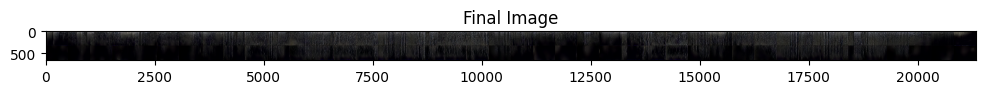

In [21]:
imshow(final_image_combined, 'Final Image')